In [1]:
import pandas as pd
import numpy as np
from coffea import util
import itertools
import os, sys
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

sys.path.append('../python/')
from functions import loadCoffeaFile, getLabelMap, getCoffeaFilenames, plotBackgroundEstimate, getHist


## analysis categories

In [2]:
# # analysis categories #
# # ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"] 
# ttagcats = ["at", "pret", "2t"]
# btagcats = ["0b", "1b", "2b"]
# ycats = ['cen', 'fwd']

# anacats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
# label_dict = {i: label for i, label in enumerate(anacats)}
# label_to_int_dict = {label: i for i, label in enumerate(anacats)}
# label_to_int_dict
# signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
# pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
# signal_cats, pretag_cats

In [3]:
IOVs = ['2016']

# analysis categories #

label_dict = loadCoffeaFile()['analysisCategories']

# label_dict = util.load(f'../outputs/QCD_{IOVs[0]}.coffea')['analysisCategories']
label_to_int_dict = {label: i for i, label in label_dict.items()}

signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int_dict.items() if 'at' in label]




In [4]:
label_dict

{0: 'at0bcen',
 1: 'at0bfwd',
 2: 'at1bcen',
 3: 'at1bfwd',
 4: 'at2bcen',
 5: 'at2bfwd',
 6: 'pret0bcen',
 7: 'pret0bfwd',
 8: 'pret1bcen',
 9: 'pret1bfwd',
 10: 'pret2bcen',
 11: 'pret2bfwd',
 12: '2t0bcen',
 13: '2t0bfwd',
 14: '2t1bcen',
 15: '2t1bfwd',
 16: '2t2bcen',
 17: '2t2bfwd'}

## scale factors and IOV

In [5]:
IOVs = ['2016']

lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2016all": 35920,
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 13700000.0 #pb From https://cms-gen-dev.cern.ch/xsdb



## save plots

In [6]:
directories = [
    'images/png/closureTestQCD/2016all',
    'images/png/closureTestQCD/2016APV',
    'images/png/closureTestQCD/2016',
    'images/png/closureTestQCD/2017',
    'images/png/closureTestQCD/2018',
    'images/pdf/closureTestQCD/2016all',
    'images/pdf/closureTestQCD/2016APV',
    'images/pdf/closureTestQCD/2016',
    'images/pdf/closureTestQCD/2017',
    'images/pdf/closureTestQCD/2018',
]


for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)

## coffea files

In [7]:
tagger='DeepAK8 top tagger'
# tagger='CMS top tagger'


coffeaFiles = getCoffeaFilenames()

# coffeaFiles



# Background Estimate

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Text(1, 0, '')

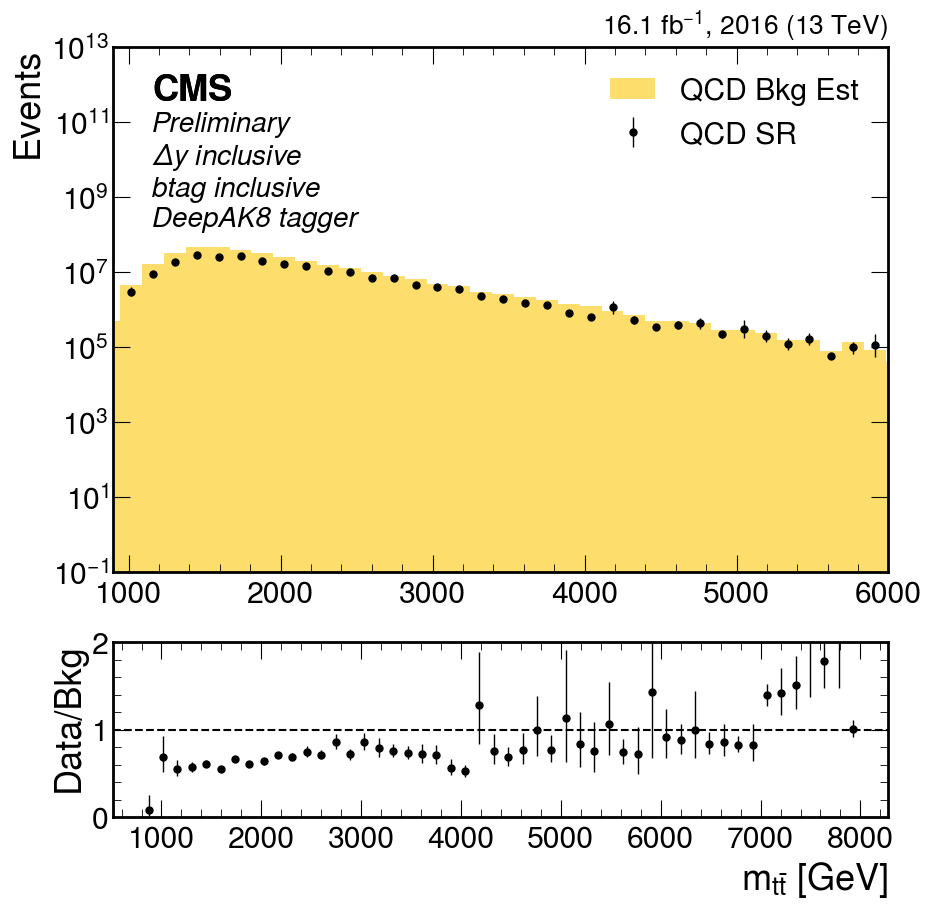

In [8]:
IOV = '2016'

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

sig = util.load(coffeaFiles['QCD']['unweighted'][IOV])
bkg = util.load(coffeaFiles['QCD']['weighted'][IOV])

qcdsf = {
    'sig': lumi[IOV] * qcd_xs / sig['cutflow']['sumw'],
    'bkg': lumi[IOV] * qcd_xs / bkg['cutflow']['sumw'],
}

hsig = sig['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum}] * qcdsf['sig']
hbkg1 = bkg['ttbarmass'][{'anacat':pretag_cats}][{'anacat':sum}] * qcdsf['bkg']

hbkg = hbkg1 #/ np.sum(f_rlf, axis=1)



hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[IOV]/1000), year=IOV, loc=2, fontsize=20, ax=ax1)
hep.cms.text('Preliminary'+'\n'+r'$\Delta y$ inclusive'+'\n'+r'btag inclusive''\n'+r'DeepAK8 tagger', loc=2, fontsize=20, ax=ax1)

hep.histplot(hsig, histtype='errorbar', color='black', label='QCD SR', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='QCD Bkg Est', ax=ax1)


ratio_plot =  hsig / hbkg.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel('Events')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e13)
ax1.set_xlim(900,6000)
ax1.set_xlabel('')


# Transfer Function

In [9]:
# fit N events from CR to N events from SR


# loose to fail | pretag to antitag

def rlf(x, mt, p0, p1):
    
    return x*(p0 + p1 * mt)


# pass to loose | signal to pretag

def rtf(x, mt, mtt, p2, p3, p4, p5):
    
    return x * ( (p2 + p3 * mt + p4 * mt * mt) * (p5 * mtt) )
    
    

In [10]:
qcd = loadCoffeaFile()


mtt_vs_mt = qcd['mtt_vs_mt'][{'anacat':pretag_cats}][{'anacat':sum}]

h2dsr = qcd['mtt_vs_mt'][{'anacat':signal_cats}][{'anacat':sum}]
h2dcr = qcd['mtt_vs_mt'][{'anacat':antitag_cats}][{'anacat':sum}]
h2dpr = qcd['mtt_vs_mt'][{'anacat':pretag_cats}][{'anacat':sum}]


qcdsf = lumi[IOV] * qcd_xs / qcd['cutflow']['sumw']

hsig_mtt = h2dsr[{'jetmass':sum}] * qcdsf
hbkg_mtt = h2dcr[{'jetmass':sum}] * qcdsf


Nsr = h2dsr.values()#*qcdsf
Ncr = h2dcr.values()#*qcdsf
Npr = h2dpr.values()#*qcdsf





/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


In [11]:
# rtf(x, mt, mtt, p2, p3, p4, p5)

bins_mt = h2dsr.axes['jetmass'].edges[:-1]
bins_mtt = h2dsr.axes['ttbarmass'].edges[:-1]


mtt, mt = np.meshgrid(bins_mtt, bins_mt)

f_mt  = mt.flatten()
f_mtt = mtt.flatten()
f_nsr = Nsr.flatten()
f_ncr = Ncr.flatten()
f_npr = Npr.flatten()


In [12]:
# loose to fail | pretag to antitag

popt, pcov = curve_fit(lambda x, p0, p1: rlf(x, f_mt, p0, p1), 
                       f_ncr, 
                       f_npr, 
                       p0=[1,1])


p0, p1 = popt

f_rlf = rlf(np.ones_like(Ncr), mt, p0, p1)


In [13]:

# pass to loose | signal to pretag


popt, pcov = curve_fit(lambda x, p2, p3, p4, p5: rtf(x, f_mt, f_mtt, p2, p3, p4, p5), 
                       f_npr, 
                       f_nsr, 
                       p0=[1,1,1,1])

p2, p3, p4, p5 = popt

f_rtf = rtf(np.ones_like(Ncr), mt, mtt, p2, p3, p4, p5)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


/tmp/ipykernel_3293/2128301779.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/tmp/ipykernel_3293/2128301779.py:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


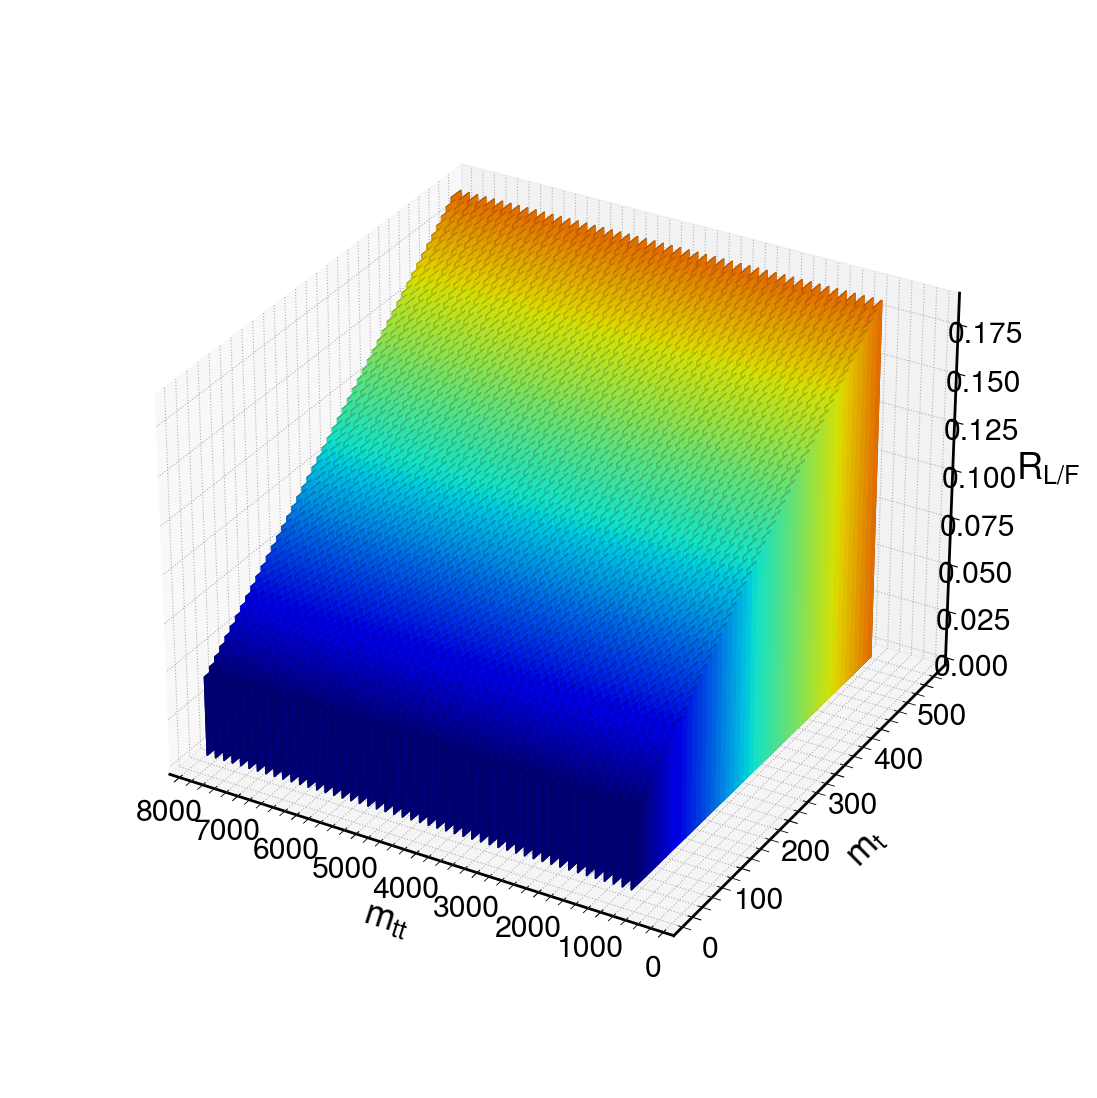

In [14]:
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(projection='3d')

x = f_mtt
y = f_mt
z = f_rlf.flatten()

bottom = np.zeros_like(z) #mtt_vs_mt.values()[1]

dx = 20
dy = 20

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

# hmin = 0.0

rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)
ax1.set_xlim(8000,0)


ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{tt}$', labelpad=20, loc='right')
ax1.set_ylabel(r'$m_t$', labelpad=20)
ax1.set_zlabel(r'$R_{L/F}$', labelpad=30)#, loc='top')#, rotation=180)

ax1.dist = 12


/tmp/ipykernel_3293/3852990331.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/tmp/ipykernel_3293/3852990331.py:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 13


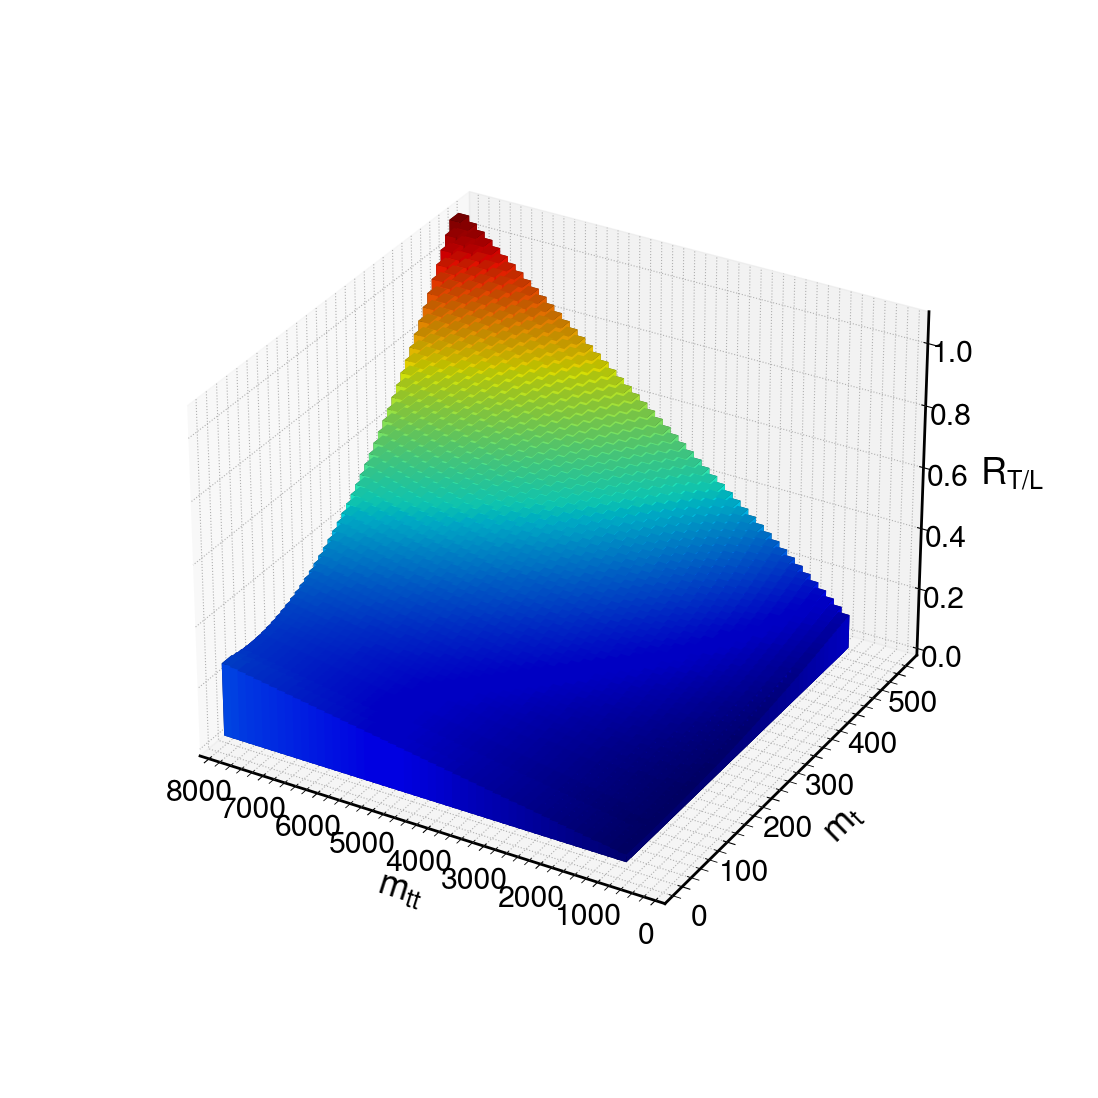

In [15]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(projection='3d')

x = f_mtt
y = f_mt

z = f_rtf.flatten()

bottom = np.zeros_like(z) #mtt_vs_mt.values()[1]

dx = 200
dy = 20

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)#, zorder=0)
ax1.set_xlim(8000,0)

ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{tt}$', labelpad=20, loc='right')
ax1.set_ylabel(r'$m_t$', labelpad=20)
ax1.set_zlabel(r'$R_{T/L}$', labelpad=30)#, loc='top')#, rotation=180)

ax1.dist = 13

plt.show()


/tmp/ipykernel_3293/3236016629.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('jet')


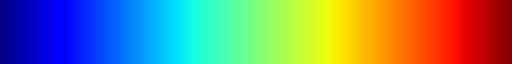

In [16]:
plt.cm.get_cmap('jet')

In [17]:
htf = loadCoffeaFile('JetHT', '2016', 'F')
htg = loadCoffeaFile('JetHT', '2016', 'G')
hth = loadCoffeaFile('JetHT', '2016', 'H')

ht_mtt = (htf['ttbarmass'] + htg['ttbarmass'] + hth['ttbarmass'])[{'anacat':antitag_cats}][{'anacat':sum}]

In [18]:
ht_mtt

Hist(Regular(50, 800, 8000, name='ttbarmass', label='$m_{t\\bar{t}}$ [GeV]'), storage=Weight()) # Sum: WeightedSum(value=2.8951e+06, variance=2.8951e+06) (WeightedSum(value=2.89564e+06, variance=2.89564e+06) with flow)

Text(1, 0, '')

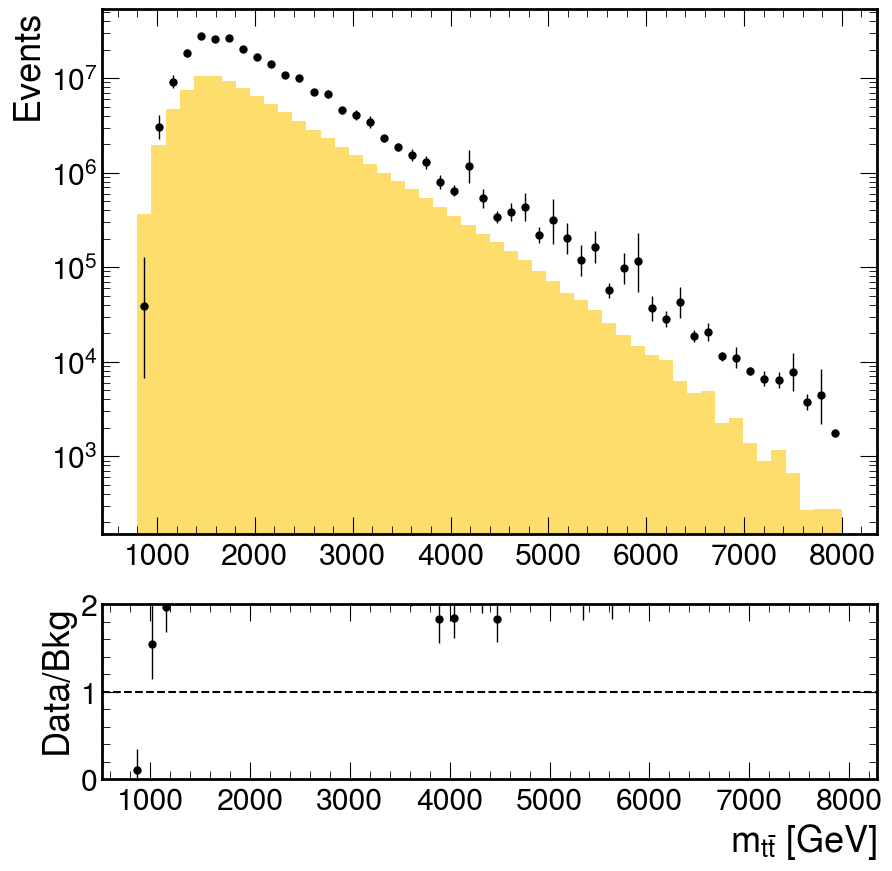

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


bins = hbkg_mtt.axes['ttbarmass'].edges[:-1]
hbkg_mtt_2 = bkg['ttbarmass'][{'anacat':antitag_cats}][{'anacat':sum}] * qcdsf#* qcdsf['bkg']


# h2 = hbkg_mtt / np.sum(f_rlf, axis=1) / np.sum(f_rtf, axis=1) #np.sum(f_rtf, axis=1)

h2 = ht_mtt * np.sum(f_rlf, axis=0) * np.sum(f_rtf, axis=0) #np.sum(f_rtf, axis=1)


hep.histplot(hsig_mtt, histtype='errorbar', color='k', ax=ax1)
ax1.set_yscale('log')
# ax1.plot(bins, h2, ls='', marker='o')
hep.histplot(h2, histtype='fill', color='xkcd:pale gold', label='QCD Bkg Est', ax=ax1)


# hep.histplot(hbkg_mtt, histtype='errorbar', color='g', label='QCD Bkg Est', ax=ax1)



# hep.histplot(hbkg_mtt, histtype='errorbar', color='g', ax=ax1)

ax1.set_ylabel('Events')

ratio_plot = hsig_mtt / h2.values()


# # ratio_plot =  values / fitted
# # yerr = ratio_plot * np.sqrt(1/values + 1/fitted)

hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_xlabel('')

# Transfer Function + Mistag Rate

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


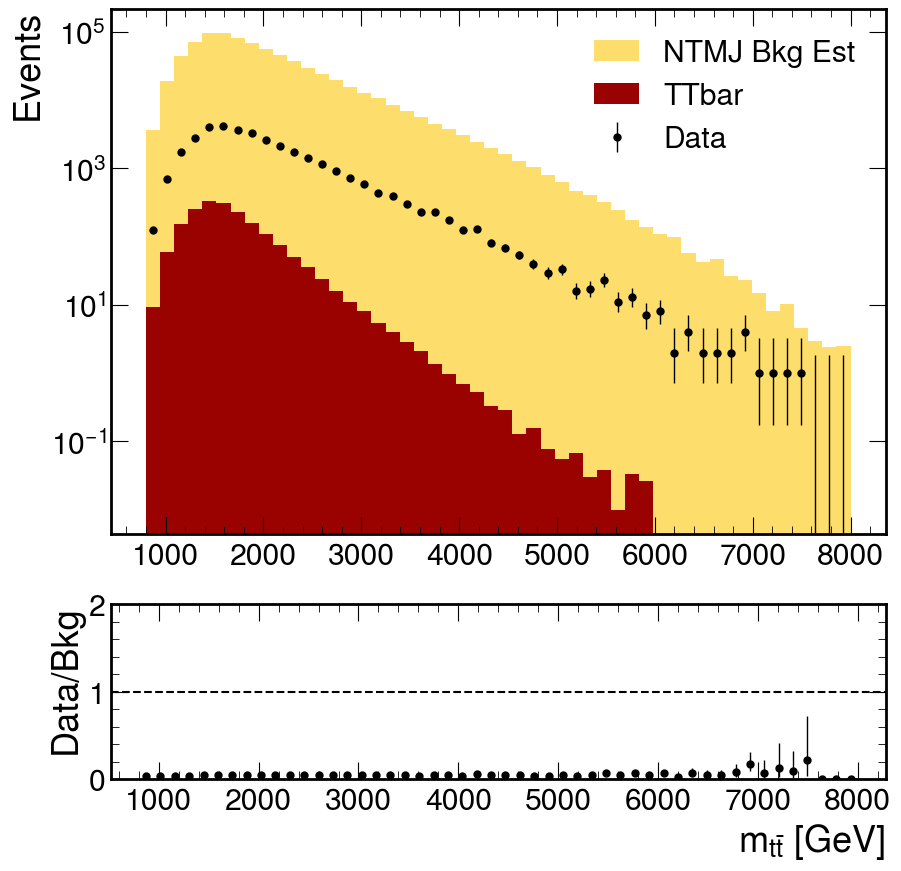

In [81]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


bins = hbkg_mtt.axes['ttbarmass'].edges[:-1]


IOV = '2016'
httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats})
hntmj = getHist('ttbarmass', 'JetHT', True, IOV, sum_axes=['anacat'], integrate_axes={'anacat':antitag_cats})
hdata = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':signal_cats})



hbkg_mr = bkg['ttbarmass'][{'anacat':antitag_cats}][{'anacat':sum}] * qcdsf#* qcdsf['bkg']




h2 = hntmj * np.sum(f_rlf, axis=1) + httbar


# h2 = hntmj / np.sum(f_rtf, axis=1) + httbar

# h2 = hntmj + httbar


hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
ax1.set_yscale('log')
# ax1.plot(bins, h2, ls='', marker='o')
hep.histplot(h2, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)


# hep.histplot(hbkg_mtt, histtype='errorbar', color='g', label='QCD Bkg Est', ax=ax1)



# hep.histplot(hbkg_mtt, histtype='errorbar', color='g', ax=ax1)

ax1.set_ylabel('Events')

ratio_plot = hdata / h2.values()


# # ratio_plot =  values / fitted
# # yerr = ratio_plot * np.sqrt(1/values + 1/fitted)

hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_xlabel('')

ax1.legend()


# ax1.set_ylim(1e2,1e4)